## Submiting: Ehud Avrahami
id: 215989815

In [23]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

custom_map = [
    "FFFFF",
    "FFFFH",
    "FFHFF",
    "FFFFG"
]
env = gym.make("FrozenLake-v1", desc=custom_map ,is_slippery=False, map_name="4x5", render_mode="human")  # Use render_mode="ansi" or "rgb_array" if not visualizing directly
for row in custom_map:
    print(" ".join(row))
    

p=[0.8,0.1,0.1] # probabilities to get to the place wanted (0.8), slippering to the right (0.1) or the left(0.1). 
gamma=0.95

F F F F F
F F F F H
F F H F F
F F F F G


c:\Users\hugo fis\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:242: RuntimeWarning: invalid value encountered in divide
  self.initial_state_distrib /= self.initial_state_distrib.sum()


# function I will use
Here i will define some function that I will use later

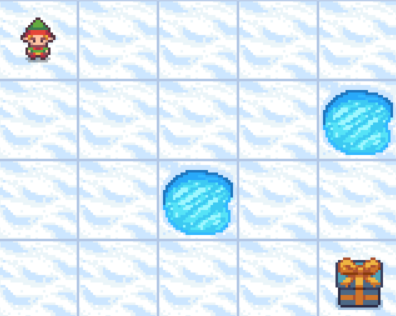

# Visualize Functions
(will be used later)

In [ ]:
def draw_policy(env, state_values, policy):
    desc = env.unwrapped.desc.astype(str)
    h, w = desc.shape
    plt.figure(figsize=(w, h))  
    V = np.array(state_values).reshape(h, w)
    Pi = np.array(policy).reshape(h, w)

    plt.imshow(V, cmap='gray', interpolation='none')
    ax = plt.gca()
    ax.set_xticks(np.arange(w) - 0.5)
    ax.set_yticks(np.arange(h) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.grid(color='blue', lw=2)
    a2uv = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
    for y in range(h):
        for x in range(w):
            state_char = desc[y, x]
            
            if state_char in ['H', 'G']:
                plt.text(x, y, state_char, color='g', ha='center', va='center', fontweight='bold', fontsize=12)
            else:
                plt.text(x, y, f"{V[y, x]:.2f}", color='black', ha='center', va='center', fontsize=8)
                a = Pi[y, x]
                if a in a2uv:
                    dx, dy = a2uv[a]
                    plt.arrow(x, y, dx * 0.3, dy * 0.3,
                              color='magenta', head_width=0.1, head_length=0.1)

    plt.title("State Values with Policy Arrows")
    plt.show()


In [ ]:
def draw_policy_and_action_values(env, q_values, policy, use_greedy=True):
    desc = env.unwrapped.desc.astype(str)
    h, w = desc.shape
    plt.figure(figsize=(w, h))
    Q = np.array(q_values).reshape(h, w, -1)
    Pi = Q.argmax(axis=2) if use_greedy else np.array(policy).reshape(h, w)
    num_actions = Q.shape[2]
    vmax = Q.max()
    vmin = Q.min()
    value_map = Q.max(axis=2)
    plt.imshow(value_map, cmap='Blues', vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.set_xticks(np.arange(w))
    ax.set_yticks(np.arange(h))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-.5, w, 1), minor=True)
    ax.set_yticks(np.arange(-.5, h, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=1)
    plt.tick_params(which="minor", bottom=False, left=False)
    a2uv={0:(-0.3,0),1:(0,0.3),2:(0.3,0),3:(0,-0.3)}
    Qmin, Qmax = Q.min(), Q.max()
    for y in range(h):
        for x in range(w):
            state_desc = desc[y, x]
            if state_desc in ['H', 'G']:
                color = 'green' if state_desc == 'G' else 'red'
                plt.text(x, y, state_desc, color=color, ha='center', va='center', fontsize=16, fontweight='bold')
                continue
            for a in range(num_actions):
                dx, dy = a2uv[a]
                q = Q[y, x, a]
                norm_q = (q - Qmin) / (Qmax - Qmin + 1e-8)
                color = plt.cm.coolwarm(norm_q)
                arrow_dx, arrow_dy = dx * 0.8, dy * 0.8
                ax.add_patch(FancyArrowPatch(
                    (x, y), (x + arrow_dx, y + arrow_dy),
                    arrowstyle='->', color=color, lw=1.5, alpha=0.6,
                    mutation_scale=8))
                text_x, text_y = x + dx * 1.2, y + dy * 1.2
                ax.text(text_x, text_y, f"{q:.2f}",color='black', fontsize=4.5, ha='center', va='center')
            a = Pi[y, x]
            if a in a2uv:
                dx, dy = a2uv[a]
                ax.add_patch(FancyArrowPatch(
                    (x, y), (x + dx * 1.2, y + dy * 1.2),
                    arrowstyle='->', color='yellow', lw=2.5, alpha=0.9,
                    mutation_scale=20))
    plt.title("Q-values with Policy Overlay", fontsize=14)
    plt.show()

# the codes for plotting (and only for plotting) the policy (with the action values and values) 
# was taken from the lecturer Idan template, and adjusted using ChatGPT  

In [ ]:
def print_array_as_map(env,array):
    desc = env.unwrapped.desc.astype(str)
    rows,cols=desc.shape
    print(np.reshape(array,(rows,cols)))

# Monte Carlo
we will explore using the Monte Carlo algorithm for Evaluation & Control

# Evaluation

### Function that will be used:

In [27]:
#FrozenLake gives reward if 1 of we win, and 0 for anything else. \
# I will want to adjust that to the requested in the assignment.
def return_reward_data(is_game_over,current_reward):
    if current_reward==1:
        return 1
    if is_game_over==False:
        return -0.08
    return -1
    

def play_and_get_state_is_game_over_and_reward(P,s,direction,probability=[0.8,0.1,0.1]):
    # P[state][action][empty brackets][_,newstate,reward,gameover]
    direction=(direction+np.random.choice([0, -1, 1], p=probability))%4 # slippering chance
    s_tilde=P[s][direction][0][1]
    is_game_over=P[s][direction][0][3]
    reward=P[s][direction][0][2] # our reward function is different, so we will change it
    return s_tilde,is_game_over,return_reward_data(is_game_over,reward)


def get_gain(R,gamma): # calculates the gain, and add in the end the reward for the terminate.
    G=np.zeros(len(R)+1) # G should have 1 more item in the array,
    #but it will be 0 cause in the terminate state there is no reward.
    for i in range(-1,-len(R)-1,-1):
        G[i-1]=R[i]+gamma*G[i]
    G[-1]=R[-1]
    return G

def new_state_by_state_and_direction(V,state,grid_size,direction): # no slippering
    V=np.reshape(V,grid_size)
    state_row=state//V.shape[1]
    state_col=state%V.shape[1]
    if direction==0:
        state_col-=1
        if state_col>=0:
            return state_row*V.shape[1]+state_col
        return state
    if direction==1:
        state_row+=1
        if state_row<V.shape[0]:
            return state_row*V.shape[1]+state_col
        return state
    if direction==2:
        state_col+=1
        if state_col<V.shape[1]:
            return state_row*V.shape[1]+state_col
        return state
    if direction==3:
        state_row-=1
        if state_row>=0:
            return state_row*V.shape[1]+state_col
        return state
    
def get_policy_from_values(V,states_visited,grid_size,policy):
    for state in states_visited: # can optimize by not repeating states already visited
        policy[state]=np.argmax((V[new_state_by_state_and_direction(V,state,grid_size,0)], #can be optimize, too many reshapes
                                V[new_state_by_state_and_direction(V,state,grid_size,1)],
                                V[new_state_by_state_and_direction(V,state,grid_size,2)],
                                V[new_state_by_state_and_direction(V,state,grid_size,3)]))
    return policy
def get_policy_from_action_values(Q,states_and_action_visited,policy): # can be optimize, return states and action, using only states
    for state,_ in states_and_action_visited: # can optimize by not repeating states already visited
        policy[state]=np.argmax((Q[state]))
    return policy

def get_least_explored_action_epsilon_greedy(action,epsilon,N_state):
    is_exploring=np.random.choice([False,True],p=[1-epsilon,epsilon])
    if not(is_exploring):
        return action
    min_indices = np.where(N_state == np.min(N_state))[0]
    return np.random.choice(min_indices)


we are in the 1000 iteration,epsilon is 1.53778990270148e-97


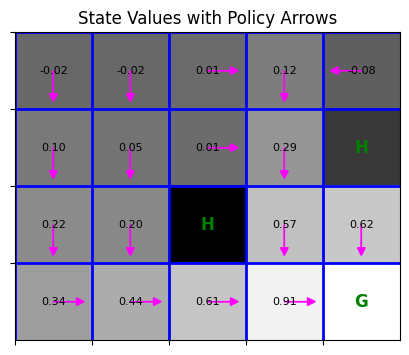

we are in the 2000 iteration,epsilon is 1.8918382278805035e-194


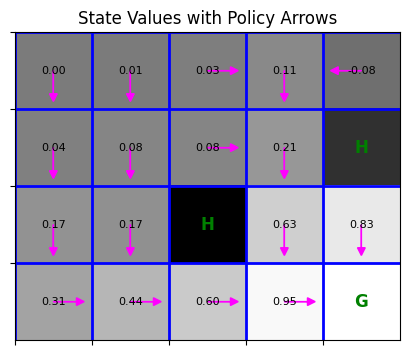

we reached convergence! this is the 2172 iteration


In [61]:
def Monte_Carlo(env,gamma,alpha,error):
    P=env.unwrapped.P
    desc = env.unwrapped.desc.astype(str)
    grid_size=desc.shape
    desc=desc.flatten()
    N=np.zeros(desc.shape)
    N_previous=np.zeros(desc.shape)
    V=np.zeros(desc.shape)
    policy=np.random.choice([0, 1, 2, 3], size=(desc.shape)) 
    # in holes and the goles the policy is meaningless
    V_previous=np.zeros(desc.shape)
    epsilon_decay_rate=0.8
    epsilon=1.00
    for i in range(1,100000):
        is_current_game_over=False
        R=[]
        states_visited=[]
        state=np.random.randint(desc.shape[0])
        counter=0
        while True:
            state = np.random.randint(desc.shape[0])
            if desc[state] not in ["H", "G"]:
                break
        while True:
            states_visited.append(state)
            if N_previous[state]==N[state]:
                N[state]+=1
            if is_current_game_over:
                break
            action=(policy[state]+np.random.choice([0,1,2,3],p=[1-epsilon,epsilon/3,epsilon/3,epsilon/3]))%4
            state,is_current_game_over,reward=play_and_get_state_is_game_over_and_reward(P,state,action)
            if counter>desc.shape[0]*5:# if it's stuck
                break
            R.append(reward)
            counter+=1
        G=get_gain(R,gamma) # for every t.
        for t,state in enumerate(states_visited):
            if N_previous[state]!=N[state]: # for first visit
                N_previous[state]+=1
                V[state]+=alpha*(G[t]-V[state])
        policy=get_policy_from_values(V,states_visited,grid_size,policy)
        if i%1000==0:
            print(f"we are in the {i} iteration,epsilon is {epsilon}")
            draw_policy(env,V,policy)
        loss = np.sum(np.square(V-V_previous))
        if loss<=error:
            print(f"we reached convergence! this is the {i} iteration")
            break
        V_previous=np.copy(V)
        epsilon = epsilon * epsilon_decay_rate

    return V,policy
monte_carlo_values,monte_carlo_policy=Monte_Carlo(env,gamma,0.01,1e-7)

# Results

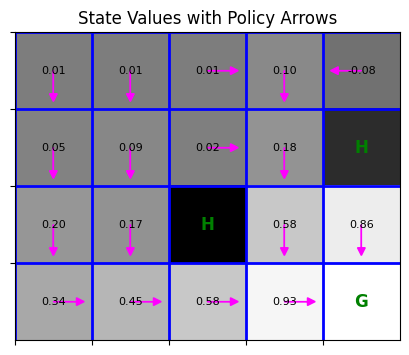

In [62]:
draw_policy(env,monte_carlo_values,monte_carlo_policy)

## The Values

In [64]:
print_array_as_map(env,np.round(monte_carlo_values,4))

[[ 0.0123  0.0081  0.0091  0.1018 -0.0753]
 [ 0.0472  0.0888  0.0241  0.1842 -0.5953]
 [ 0.2     0.1719 -0.94    0.5782  0.8595]
 [ 0.3362  0.4455  0.5823  0.926   1.    ]]


# Control

this is the 20000 iteration


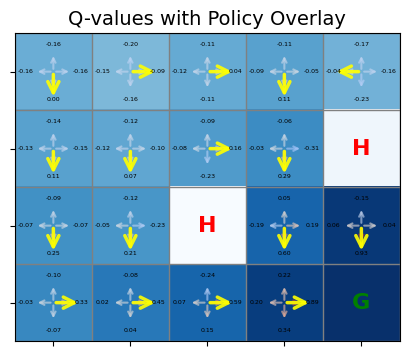

this is the 40000 iteration


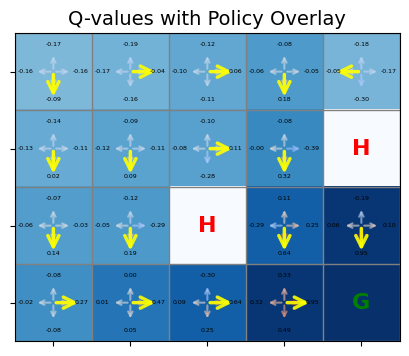

this is the 60000 iteration


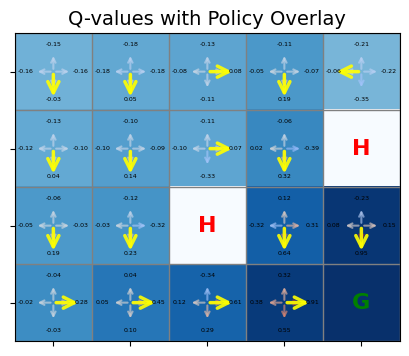

converged! this is the 67879 iteration


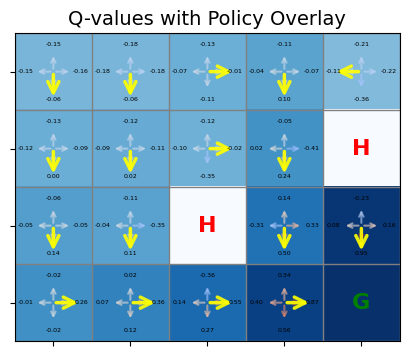

In [50]:
def Monte_Carlo_action_value(env,gamma,alpha,error):
    P=env.unwrapped.P
    desc = env.unwrapped.desc.astype(str)
    desc=desc.flatten()
    Q=np.zeros((desc.shape[0],4))
    N=np.zeros(Q.shape)
    N_previous=np.zeros(Q.shape)
    policy=np.random.choice([0, 1, 2, 3], size=(desc.shape)) 
    # in holes and the goles the policy is meaningless
    Q_previous=np.zeros(Q.shape)
    for i in range(1,500000):
        is_current_game_over=False
        R=[]
        states_and_action_visited=[]
        while True:
            state = np.random.randint(desc.shape[0])
            if desc[state] not in ["H", "G"]:
                break
        while True:
            epsilon=1/(np.sum(np.delete(N[state],policy[state]))+1)
            action=get_least_explored_action_epsilon_greedy(policy[state],epsilon,N[state]) #epsilon greedy
            states_and_action_visited.append([state,action])
            if N_previous[state,action]==N[state,action]:
                N[state,action]+=1
            if is_current_game_over:
                break
            state,is_current_game_over,reward=play_and_get_state_is_game_over_and_reward(P,state,action)
            R.append(reward)
            
        G=get_gain(R,gamma) # for every t.
        for t,current_state_action in enumerate(states_and_action_visited):
            state,action=current_state_action
            if N_previous[state,action]!=N[state,action]: # for first visit
                N_previous[state,action]+=1
                Q[state,action]+=alpha*(G[t]-Q[state,action])

        loss=np.sum(np.square(Q-Q_previous))
        if loss<=error:
            print(f"converged! this is the {i} iteration")
            draw_policy_and_action_values(env,Q,policy)
            break
        if i%100000==0:
            break
        policy=get_policy_from_action_values(Q,states_and_action_visited,policy)
        if i%20000==0:
            print(f"this is the {i} iteration")
            draw_policy_and_action_values(env,Q,policy)
        # if loss<=error:
        #     break
        Q_previous=np.copy(Q)
        
    return Q,policy
monte_carlo_action_values,monte_carlo_action_policy=Monte_Carlo_action_value(env,gamma,0.01,1e-9)

# Results

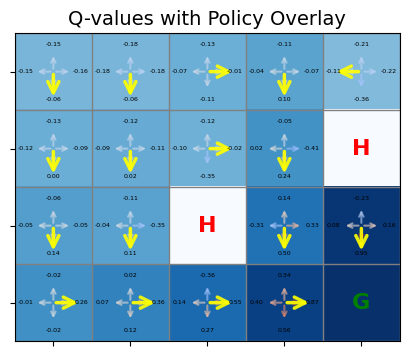

In [66]:
draw_policy_and_action_values(env,monte_carlo_action_values,monte_carlo_action_policy)

# The Action Values:


In [67]:
print(monte_carlo_action_values) # the line of just -1 is one of the hole, just the initializing.

[[-0.15306501 -0.06275272 -0.15933091 -0.14702035]
 [-0.17781341 -0.06312842 -0.18028619 -0.18387691]
 [-0.06605795 -0.11436862 -0.00730137 -0.13008953]
 [-0.03546403  0.09737876 -0.0715105  -0.10847191]
 [-0.10997208 -0.3592041  -0.21669304 -0.2082267 ]
 [-0.11760844  0.00450778 -0.09496681 -0.12530594]
 [-0.09414539  0.01664923 -0.1093484  -0.11816775]
 [-0.10369916 -0.35128166 -0.02153412 -0.11840458]
 [ 0.01899298  0.243515   -0.41192687 -0.05003326]
 [-0.99968419 -0.999681   -0.999681   -0.999681  ]
 [-0.04652075  0.13751258 -0.04812938 -0.05756571]
 [-0.03869605  0.10931477 -0.35136159 -0.10825626]
 [-1.         -1.         -1.         -1.        ]
 [-0.30877989  0.49735491  0.33165577  0.14095565]
 [ 0.08366651  0.95075944  0.16034989 -0.2283757 ]
 [-0.01184326 -0.02097627  0.26364143 -0.02295674]
 [ 0.06571551  0.11500957  0.36010047  0.02138877]
 [ 0.14293172  0.27460815  0.55304175 -0.35903817]
 [ 0.40216189  0.56336388  0.86740058  0.33712437]
 [ 1.          0.65538782  0.65

# Conclusion
We have seen the Monte Carlo algorithm, in both of its variations- control & evaluate.\
We got good results, but the evaluation process took much less epochs to converge, in contrast \
to the control process.
The results satisfies the expections.